## Predicting ICD Codes - A Multi-Class Classfication Problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline


from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

pd.set_option('max_colwidth', 400)
warnings.filterwarnings("ignore")

### The Data
Below, the data is loaded and the text (lines from diagnostics reports) is tokenized for use by various modeling techinques hereafter.

In [2]:
import nltk

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def tokenizer(row):
    '''
    This function takes in a string of text and
    returns a string of all unique tokens after removing
    stop words, stemming and lemmatizing the words
    and converting all words to lower case.

    Arguments
    ---------
    text: str
        string of text to be tokenized

    Returns
    -------
    str
       string of unique words lower cased, stemmed and lemmatized 
       with no stop words from the text input
    '''
    swords = stopwords.words('english')
    
    tokens = set(nltk.word_tokenize(row['text']))    
    
    tokens_without_stop_words = [token for token in tokens if not token in swords]    
    
    stemmer = PorterStemmer()
    stems = set([stemmer.stem(token) for token in tokens_without_stop_words])    
    
    lemma = WordNetLemmatizer()
    lemmas = set([lemma.lemmatize(token) for token in stems])  
    
    words = [token.lower() for token in lemmas]    
    
    return ' '.join(words)

In [3]:
df_lines = pd.read_csv('data/discharge_note_lines_2.csv', sep='|')

df_lines = df_lines.loc[df_lines['valid'] == True]

df_lines['tokens'] = df_lines.apply(tokenizer, axis=1)

df_lines.head()

,line_id,text,icd_code,valid,phase,tokens
64,2718,Father - T2DM Cesarean supracervical hysterectomy Postpartum hemorrhage,O24424,True,4,father postpartum supracerv cesarean hemorrhag t2dm hysterectomi -
186,9488,DM HTN CKD Gout No known family hx of kidney disease or kidney stones. AOCKD,E1122,True,2,stone famili aockd gout dm diseas htn ckd hx . known kidney no
187,8766,Prediabetes Hypertension Dyslipidemia Rosacea Umbilical herniorrhapy Appendectomy Paternal h/o MI (age ___ Maternal uncles h/o MI,R7303,True,3,uncl mi herniorrhapi prediabet dyslipidemia ___ rosacea hypertens umbil ( h/o age appendectomi patern matern
246,12025,STEMI PREDIABETES,R7303,True,3,stemi prediabet
426,8685,Diabetic ketoacidosis Influenza A Type 1 Diabetes Metabolic syndrome,E1010,True,1,influenza diabet type ketoacidosi syndrom 1 a metabol


### Test / Train Split

In [4]:
X = df_lines.drop('icd_code', axis = 1)
y = df_lines['icd_code']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X['tokens'], y, random_state = 42)

In [6]:
print('Training dataset count: ' + str(len(X_train.index)))
print('Test dataset count: ' + str(len(X_test.index)))

Training dataset count: 243
Test dataset count: 81


### Logistic Regression

In [7]:
def evaluate_estimator(name, vectorizer, classifier, params):    
    pipe = Pipeline([
        ('vect', vectorizer), 
        ('estimator', classifier)
    ])
    
    start = time.time()
    
    grid = GridSearchCV(pipe, param_grid=params).fit(X_train, y_train)
    
    end = time.time()
    
    y_pred = grid.best_estimator_.predict(X_test)
    
    cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    
    return pd.DataFrame([{
        'estimator': name, 
        'fit_time': round((end - start), 2), 
        'accuracy': round(cr["accuracy"], 4), 
        'f1-score(macro)': round(cr["macro avg"]["f1-score"], 4),
        'f1-score(weighted)': round(cr["weighted avg"]["f1-score"], 4), 
        'best_params':grid.best_params_,
        'best_estimator': grid.best_estimator_
    }])    

In [8]:
def build_confusion_matrix(preds, title):
    '''
    This function takes in predictions and draws 
    the confusion matrix against test data.

    Arguments
    ---------
    preds: Series
        Predictions against the test data
    title: string
        Title of the plot
    '''   
    plt.figure(figsize = (6,3))
    conf_matrix = confusion_matrix(y_test, preds)
    sns.heatmap(conf_matrix, annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()
    
    # ROC Curve
    #fpr, tpr, thresholds = roc_curve(y_test, pd.Series(y_score), pos_label='Yes')
    #roc_auc_value = auc(fpr, tpr)

    #disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
    #disp2.plot()
    return;

#### Text Vectorization using Count Vectorizer
Use of vectorization tool CountVectorizer to create a bag of words representation of text in a DataFrame.
Using Pipeline with named steps to vectorize and model the data, and using grid search for the ideal parameters to represent the text and build a classification model.
Logistics Regression techniques being evaluated:
- One vs. Rest classification, 
- Multinomial classification, and 
- One vs one classifier techniques

In [9]:
params = {
    'vect__max_features': [100, 200, 500, 1000, 2000],
    'vect__stop_words': ['english', None]
}

In [10]:
df_bow_comp = pd.DataFrame()

df = evaluate_estimator('ovr', CountVectorizer(), LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42), params)
df_bow_comp = pd.concat([df_bow_comp, df], ignore_index=True)

df = evaluate_estimator('multi', CountVectorizer(), LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42), params)
df_bow_comp = pd.concat([df_bow_comp, df], ignore_index=True)

df = evaluate_estimator('ovo', CountVectorizer(), OneVsOneClassifier(LogisticRegression(max_iter=1000, random_state = 42)), params)
df_bow_comp = pd.concat([df_bow_comp, df], ignore_index=True)

df_bow_comp.head()

,estimator,fit_time,accuracy,f1-score(macro),f1-score(weighted),best_params,best_estimator
0,ovr,3.92,0.8395,0.7056,0.7965,"{'vect__max_features': 200, 'vect__stop_words': None}","(CountVectorizer(max_features=200), LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42))"
1,multi,3.08,0.8395,0.7056,0.7965,"{'vect__max_features': 100, 'vect__stop_words': 'english'}","(CountVectorizer(max_features=100, stop_words='english'), LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42))"
2,ovo,17.11,0.8519,0.7395,0.8225,"{'vect__max_features': 100, 'vect__stop_words': 'english'}","(CountVectorizer(max_features=100, stop_words='english'), OneVsOneClassifier(estimator=LogisticRegression(max_iter=1000, random_state=42)))"


##### Evaluation: 
Compare the scores on testing data in terms of accuracy.

In [11]:
best_bow_acc = df_bow_comp.loc[df_bow_comp['accuracy'].idxmax()]['estimator']

print('Best Performance: ' + best_bow_acc)

Best Performance: ovo


###### Confusion Matrices

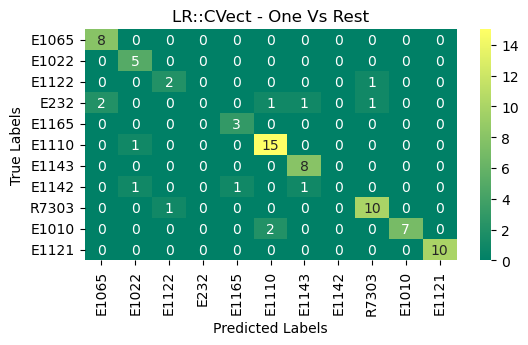

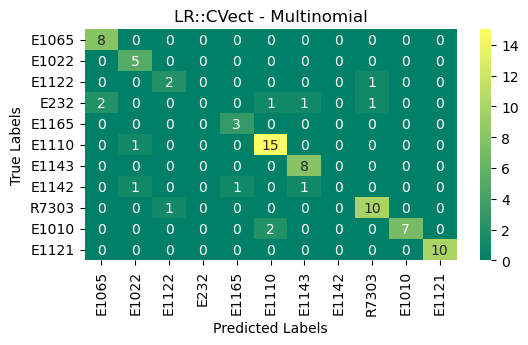

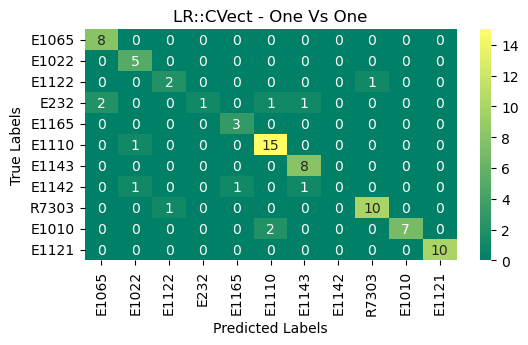

In [12]:
build_confusion_matrix(df_bow_comp.loc[0, 'best_estimator'].predict(X_test), 'LR::CVect - One Vs Rest') 
build_confusion_matrix(df_bow_comp.loc[1, 'best_estimator'].predict(X_test), 'LR::CVect - Multinomial')
build_confusion_matrix(df_bow_comp.loc[2, 'best_estimator'].predict(X_test), 'LR::CVect - One Vs One')

#### Text Vectorization using TFIDF
Use of vectorization tool TfidfVectorizer.
Using Pipeline with named steps to vectorize and model the data, and using grid search for the ideal parameters to represent the text and build a classification model.
Logistics Regression techniques being evaluated:
- One vs. Rest classification, 
- Multinomial classification, and 
- One vs one classifier techniques

In [13]:
df_tfidf_comp = pd.DataFrame()

df = evaluate_estimator('ovr', TfidfVectorizer(), LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42), params)
df_tfidf_comp = pd.concat([df_tfidf_comp, df], ignore_index=True)

df = evaluate_estimator('multi', TfidfVectorizer(), LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42), params)
df_tfidf_comp = pd.concat([df_tfidf_comp, df], ignore_index=True)

df = evaluate_estimator('ovo', TfidfVectorizer(), OneVsOneClassifier(LogisticRegression(max_iter=1000, random_state = 42)), params)
df_tfidf_comp = pd.concat([df_tfidf_comp, df], ignore_index=True)

df_tfidf_comp.head()

,estimator,fit_time,accuracy,f1-score(macro),f1-score(weighted),best_params,best_estimator
0,ovr,2.96,0.7778,0.6357,0.7339,"{'vect__max_features': 100, 'vect__stop_words': 'english'}","(TfidfVectorizer(max_features=100, stop_words='english'), LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42))"
1,multi,2.25,0.7901,0.6573,0.7501,"{'vect__max_features': 100, 'vect__stop_words': 'english'}","(TfidfVectorizer(max_features=100, stop_words='english'), LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42))"
2,ovo,12.85,0.6790,0.5060,0.6267,"{'vect__max_features': 100, 'vect__stop_words': 'english'}","(TfidfVectorizer(max_features=100, stop_words='english'), OneVsOneClassifier(estimator=LogisticRegression(max_iter=1000, random_state=42)))"


##### Evaluation: 
Compare the scores on testing data in terms of accuracy.

In [14]:
best_tfidf_acc = df_tfidf_comp.loc[df_tfidf_comp['accuracy'].idxmax()]['estimator']

print('Best Performance: ' + best_tfidf_acc)

Best Performance: multi


###### Confusion Matrices

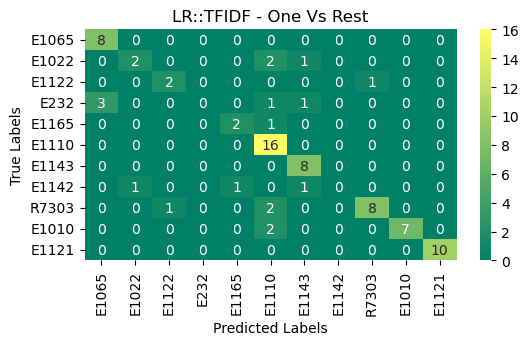

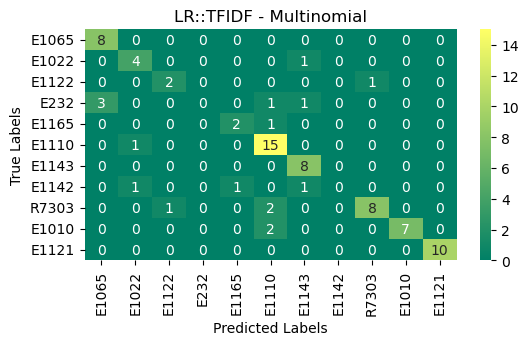

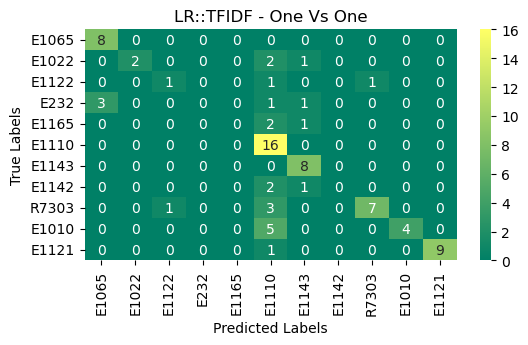

In [15]:
build_confusion_matrix(df_tfidf_comp.loc[0, 'best_estimator'].predict(X_test), 'LR::TFIDF - One Vs Rest')
build_confusion_matrix(df_tfidf_comp.loc[1, 'best_estimator'].predict(X_test), 'LR::TFIDF - Multinomial')
build_confusion_matrix(df_tfidf_comp.loc[2, 'best_estimator'].predict(X_test), 'LR::TFIDF - One Vs One')

### Naive Bayes
Text vectorization strategies
- Count Vectorization
- TFIDF

In [16]:
df_nb_comp = pd.DataFrame()

df = evaluate_estimator('nb-cvect', CountVectorizer(), MultinomialNB(), params)
df_nb_comp = pd.concat([df_nb_comp, df], ignore_index=True)

df = evaluate_estimator('nb-tfidf', TfidfVectorizer(), MultinomialNB(), params)
df_nb_comp = pd.concat([df_nb_comp, df], ignore_index=True)

df_nb_comp.head()

,estimator,fit_time,accuracy,f1-score(macro),f1-score(weighted),best_params,best_estimator
0,nb-cvect,0.48,0.7778,0.6713,0.7479,"{'vect__max_features': 200, 'vect__stop_words': None}","(CountVectorizer(max_features=200), MultinomialNB())"
1,nb-tfidf,0.58,0.6543,0.4809,0.6031,"{'vect__max_features': 100, 'vect__stop_words': 'english'}","(TfidfVectorizer(max_features=100, stop_words='english'), MultinomialNB())"


##### Evaluation: 
Compare the scores on testing data in terms of accuracy.

In [17]:
best_nb_acc = df_nb_comp.loc[df_nb_comp['accuracy'].idxmax()]['estimator']

print('Best Performance: ' + best_nb_acc)

Best Performance: nb-cvect


###### Confusion Matrices

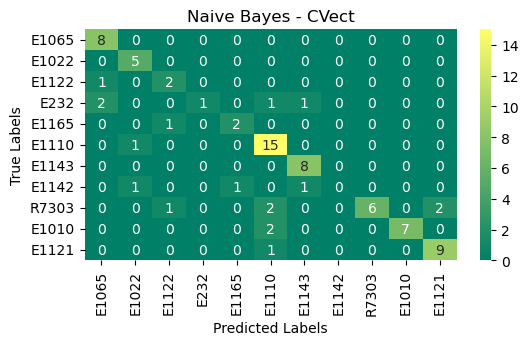

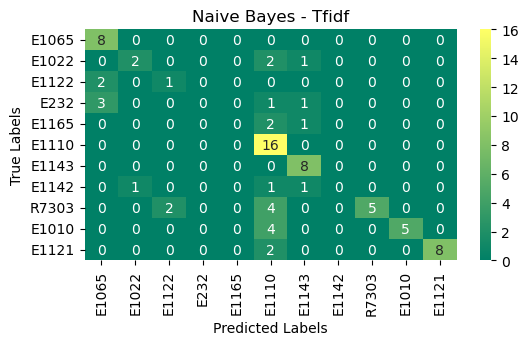

In [18]:
build_confusion_matrix(df_nb_comp.loc[0, 'best_estimator'].predict(X_test), 'Naive Bayes - CVect')
build_confusion_matrix(df_nb_comp.loc[1, 'best_estimator'].predict(X_test), 'Naive Bayes - Tfidf')

### Support Vector Machine (SVM)
Text vectorization strategies with two different classifiers; one with Polynomial kernel, and the other with RBF kernel.
- Count Vectorization
- TFIDF

In [19]:
df_svm_comp = pd.DataFrame()

df = evaluate_estimator('svm-rbf-cvect', CountVectorizer(), SVC(kernel='rbf', gamma=0.5, C=0.1), params)
df_svm_comp = pd.concat([df_svm_comp, df], ignore_index=True)

df = evaluate_estimator('svm-poly-cvect', CountVectorizer(), SVC(kernel='poly', degree=3, C=1), params)
df_svm_comp = pd.concat([df_svm_comp, df], ignore_index=True)

df = evaluate_estimator('svm-rbf-tfidf', TfidfVectorizer(), SVC(kernel='rbf', gamma=0.5, C=0.1), params)
df_svm_comp = pd.concat([df_svm_comp, df], ignore_index=True)

df = evaluate_estimator('svm-poly-tfidf', TfidfVectorizer(), SVC(kernel='poly', degree=3, C=1), params)
df_svm_comp = pd.concat([df_svm_comp, df], ignore_index=True)

df_svm_comp.head()

,estimator,fit_time,accuracy,f1-score(macro),f1-score(weighted),best_params,best_estimator
0,svm-rbf-cvect,1.15,0.1975,0.0300,0.0652,"{'vect__max_features': 100, 'vect__stop_words': 'english'}","(CountVectorizer(max_features=100, stop_words='english'), SVC(C=0.1, gamma=0.5))"
1,svm-poly-cvect,1.24,0.5556,0.4647,0.5066,"{'vect__max_features': 100, 'vect__stop_words': None}","(CountVectorizer(max_features=100), SVC(C=1, kernel='poly'))"
2,svm-rbf-tfidf,1.28,0.1975,0.0300,0.0652,"{'vect__max_features': 100, 'vect__stop_words': 'english'}","(TfidfVectorizer(max_features=100, stop_words='english'), SVC(C=0.1, gamma=0.5))"
3,svm-poly-tfidf,1.39,0.7160,0.5839,0.6786,"{'vect__max_features': 100, 'vect__stop_words': 'english'}","(TfidfVectorizer(max_features=100, stop_words='english'), SVC(C=1, kernel='poly'))"


##### Evaluation: 
Compare the scores on testing data in terms of accuracy.

In [20]:
best_svm_acc = df_svm_comp.loc[df_svm_comp['accuracy'].idxmax()]['estimator']

print('Best Performance: ' + best_svm_acc)

Best Performance: svm-poly-tfidf


###### Confusion Matrices

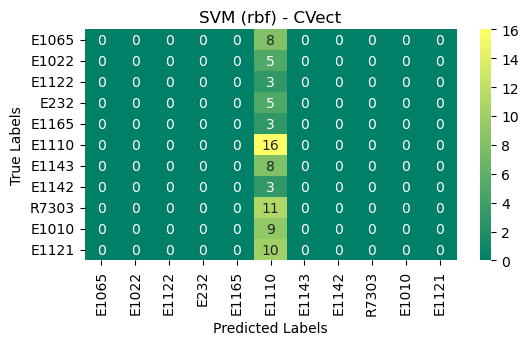

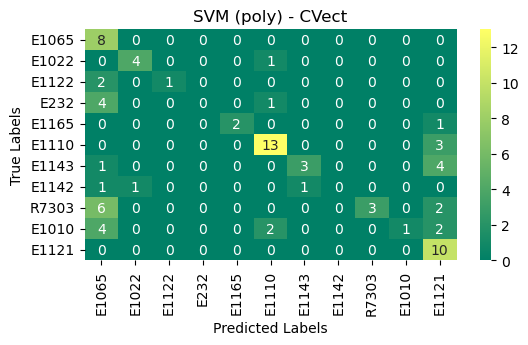

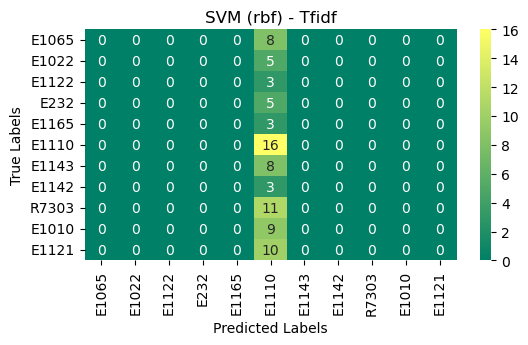

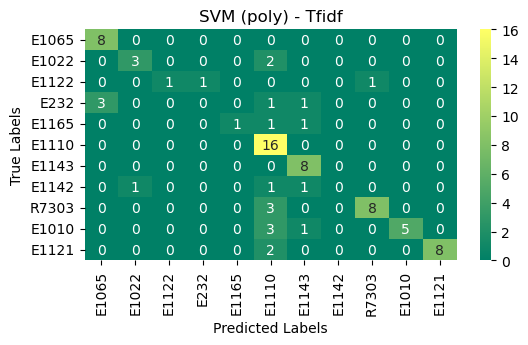

In [21]:
build_confusion_matrix(df_svm_comp.loc[0, 'best_estimator'].predict(X_test), 'SVM (rbf) - CVect')
build_confusion_matrix(df_svm_comp.loc[1, 'best_estimator'].predict(X_test), 'SVM (poly) - CVect')
build_confusion_matrix(df_svm_comp.loc[2, 'best_estimator'].predict(X_test), 'SVM (rbf) - Tfidf')
build_confusion_matrix(df_svm_comp.loc[3, 'best_estimator'].predict(X_test), 'SVM (poly) - Tfidf')

### AdaBoost Classifier
Text vectorization strategies with LogisticRegresion estimator.
- Count Vectorization
- TFIDF

In [24]:
params = {
    'vect__max_features': [100, 200, 500, 1000, 2000],
    'vect__stop_words': ['english', None],
    'estimator__base_estimator__C': [0.01, 0.1, 1.0, 10.0]
}

In [25]:
df_ab_comp = pd.DataFrame()

lr = LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42)

df = evaluate_estimator('ada-lr-ovr-cvect', CountVectorizer(), AdaBoostClassifier(base_estimator = lr, random_state = 42), params)
df_ab_comp = pd.concat([df_ab_comp, df], ignore_index=True)

df = evaluate_estimator('ada-lr-ovr-tfidf', TfidfVectorizer(), AdaBoostClassifier(base_estimator = lr, random_state = 42), params)
df_ab_comp = pd.concat([df_ab_comp, df], ignore_index=True)

lr = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)

df = evaluate_estimator('ada-lr-multi-cvect', CountVectorizer(), AdaBoostClassifier(base_estimator = lr, random_state = 42), params)
df_ab_comp = pd.concat([df_ab_comp, df], ignore_index=True)

df = evaluate_estimator('ada-lr-multi-tfidf', TfidfVectorizer(), AdaBoostClassifier(base_estimator = lr, random_state = 42), params)
df_ab_comp = pd.concat([df_ab_comp, df], ignore_index=True)

df_ab_comp.head()

,estimator,fit_time,accuracy,f1-score(macro),f1-score(weighted),best_params,best_estimator
0,ada-lr-ovr-cvect,468.94,0.8025,0.6602,0.7642,"{'estimator__base_estimator__C': 10.0, 'vect__max_features': 200, 'vect__stop_words': 'english'}","(CountVectorizer(max_features=200, stop_words='english'), (LogisticRegression(C=10.0, max_iter=1000, multi_class='ovr',\n random_state=1608637542), LogisticRegression(C=10.0, max_iter=1000, multi_class='ovr',\n random_state=1273642419), LogisticRegression(C=10.0, max_iter=1000, multi_class='ovr',\n random_state=1935803228), LogisticRegressi..."
1,ada-lr-ovr-tfidf,402.24,0.7654,0.6591,0.7392,"{'estimator__base_estimator__C': 10.0, 'vect__max_features': 100, 'vect__stop_words': None}","(TfidfVectorizer(max_features=100), (LogisticRegression(C=10.0, max_iter=1000, multi_class='ovr',\n random_state=1608637542), LogisticRegression(C=10.0, max_iter=1000, multi_class='ovr',\n random_state=1273642419), LogisticRegression(C=10.0, max_iter=1000, multi_class='ovr',\n random_state=1935803228), LogisticRegression(C=10.0, max_iter=10..."
2,ada-lr-multi-cvect,264.45,0.8025,0.6602,0.7642,"{'estimator__base_estimator__C': 10.0, 'vect__max_features': 200, 'vect__stop_words': 'english'}","(CountVectorizer(max_features=200, stop_words='english'), (LogisticRegression(C=10.0, max_iter=1000, multi_class='multinomial',\n random_state=1608637542), LogisticRegression(C=10.0, max_iter=1000, multi_class='multinomial',\n random_state=1273642419), LogisticRegression(C=10.0, max_iter=1000, multi_class='multinomial',\n random_state=19358..."
3,ada-lr-multi-tfidf,211.76,0.7654,0.6560,0.7413,"{'estimator__base_estimator__C': 10.0, 'vect__max_features': 100, 'vect__stop_words': None}","(TfidfVectorizer(max_features=100), (LogisticRegression(C=10.0, max_iter=1000, multi_class='multinomial',\n random_state=1608637542), LogisticRegression(C=10.0, max_iter=1000, multi_class='multinomial',\n random_state=1273642419), LogisticRegression(C=10.0, max_iter=1000, multi_class='multinomial',\n random_state=1935803228), LogisticRegres..."


##### Evaluation: 
Compare the scores on testing data in terms of accuracy.

In [27]:
best_ab_acc = df_ab_comp.loc[df_ab_comp['accuracy'].idxmax()]['estimator']

print('Best Performance: ' + best_ab_acc)

Best Performance: ada-lr-ovr-cvect


###### Confusion Matrices

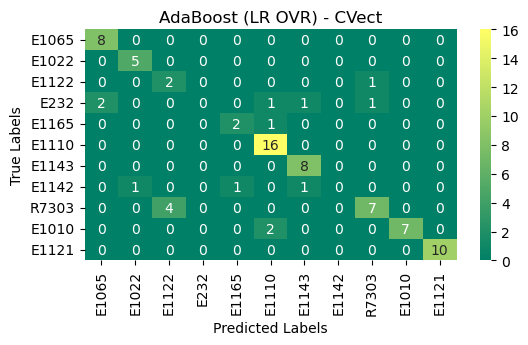

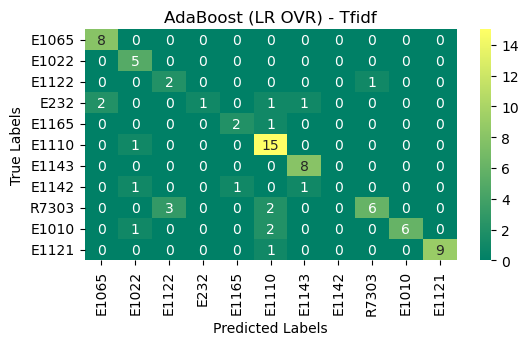

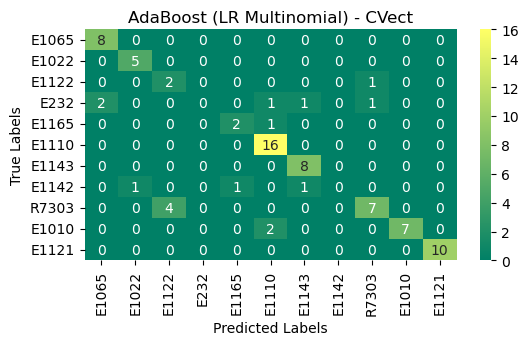

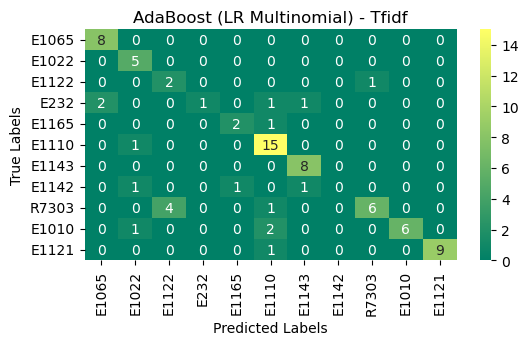

In [28]:
build_confusion_matrix(df_ab_comp.loc[0, 'best_estimator'].predict(X_test), 'AdaBoost (LR OVR) - CVect')
build_confusion_matrix(df_ab_comp.loc[1, 'best_estimator'].predict(X_test), 'AdaBoost (LR OVR) - Tfidf')
build_confusion_matrix(df_ab_comp.loc[2, 'best_estimator'].predict(X_test), 'AdaBoost (LR Multinomial) - CVect')
build_confusion_matrix(df_ab_comp.loc[3, 'best_estimator'].predict(X_test), 'AdaBoost (LR Multinomial) - Tfidf')